### This project aims to classify the gender of names using a letter level neural network. First, the data needs to be prepared. We read in the data and split it into a training and held out set.

In [1]:
import pandas as pd
import torch

In [2]:
df = pd.read_csv('name_gender_dataset.csv')
df.head()

,Name,Gender,Count,Probability
0,James,M,5304407,0.014517
1,John,M,5260831,0.014398
2,Robert,M,4970386,0.013603
3,Michael,M,4579950,0.012534
4,William,M,4226608,0.011567


In [5]:
# Build a dict with list of male and female names
all_data = {}
all_data["M"] = []
all_data["F"] = []
for i, row in df.iterrows():
    gender = row["Gender"]
    all_data[gender].append(row["Name"])

print("Length of male names: ", len(all_data["M"]))
print(all_data["M"][:5])

print("Length of female names: ", len(all_data["F"]))
print(all_data["F"][:5])

Length of male names:  57520
['James', 'John', 'Robert', 'Michael', 'William']
Length of female names:  89749
['Mary', 'Elizabeth', 'Patricia', 'Jennifer', 'Linda']


In [8]:
# Want to split the data into training and held out set
# First, need to randomly shuffle each list since they are sorted by count/probability
import random
random.shuffle(all_data["M"])
random.shuffle(all_data["F"])
print(all_data["M"][:5])
print(all_data["F"][:5])

['Ethan-James', 'Trimayne', 'Tru', 'Johee', 'Uma']
['Galina', 'Shakara', 'Fawnia', 'Uroosa', 'Akaylah']


In [13]:
# Use ~80% for training and rest for testing
# Since we already randomly shuffled we can split by index
len_M_training = int(len(all_data["M"]) * .8)
len_M_test = len(all_data["M"]) - len_M_training

len_F_training = int(len(all_data["F"]) * .8)
len_F_test = len(all_data["M"]) - len_F_training


training_data = {}
test_data = {}

training_data["M"] = all_data["M"][0:len_M_training]
test_data["M"] = all_data["M"][len_M_training:]

training_data["F"] = all_data["F"][0:len_F_training]
test_data["F"] = all_data["F"][len_F_training:]

### Next, we need some helper functions to turn each name into vectors. We use a one-hot vector representation of each letter to do this

In [15]:
import torch
import unicodedata
import string

# Get list of all letters so we can use their indices to form vectors
# Where the corresponding index of the letter is the position in its vector where the value is 1, and the rest are 0
all_letters = string.ascii_letters
n_letters = len(all_letters)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('Tru'))
print(lineToTensor('Tru').size())


tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]])
torch.Size([3, 1, 52])


### Now we can define the neural network we will use. We use just 2 layers (input to hidden and hidden to output) and a relatively small hidden size of 128. We also use a log softmax layer on the output to normalize probabilities

In [22]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        # init layers and softmax function
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # take the products of the input and NN layers
        combined = torch.cat((input, hidden), 1)
        # update hidden state
        hidden = self.i2h(combined)
        # compute output with softmax
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
# Use reccommended hidden size 128 and output size 2 for each gender
n_hidden = 128
n_classes = 2
rnn = RNN(n_letters, n_hidden, n_classes)

### We can demonstrate the output and new hidden state as a result of a forward pass on a single example:

In [23]:
input = lineToTensor('Mary')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print("output: ", output)
print("next hidden: ", hidden)

output:  tensor([[-0.6799, -0.7065]], grad_fn=<LogSoftmaxBackward0>)
next hidden:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])


### Before we can start training the Neural Network we need a few helpers

In [26]:
# Get the gender from output probability vector
all_categories = ["M", "F"]
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('M', 0)


In [28]:
# Functions to pick test and training examples at random
# Instead of going through each example x amount of times, we will just randomly sample 
# The random selection can reduce noise and control for unequal number of male and female names
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(training_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTestExample():
    category = randomChoice(all_categories)
    line = randomChoice(test_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = M / line = Olivier
category = F / line = Mauricia
category = F / line = Coraine
category = F / line = Nalanee
category = F / line = Luvinah
category = F / line = Debraoh
category = F / line = Mora
category = M / line = Typan
category = M / line = Denay
category = M / line = Palash


### Define the training function with some hyperparameters:

For each word, we reset the hidden layer and update the output and hidden state letter by letter, so that the hidden layer only encodes information about the previous letters in the word. Then we compute the loss and use it to update the parameter gradients.

In [30]:
# We use negative log likelihood loss, recommended for classification problems & with log softmax output
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    # initialize new hidden layer
    hidden = rnn.initHidden()
    # set gradients to 0
    rnn.zero_grad()
    # train letter by letter 
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

### Now we are ready to train

We iterate over randomly selected training examples, printing out progress and guesses to keep an eye on progress. We keep track of losses to plot them afterwards

In [31]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 0.2753 Tanikah-Jemma / F ✓
10000 10% (0m 15s) 0.5101 Seydi / F ✓
15000 15% (0m 23s) 2.8297 Adnya / F ✗ (M)
20000 20% (0m 31s) 0.4657 Lisette-Marie / F ✓
25000 25% (0m 38s) 0.5563 Abbey-Kate / F ✓
30000 30% (0m 45s) 1.7960 Idika / F ✗ (M)
35000 35% (0m 52s) 0.4410 Meharveer / M ✓
40000 40% (1m 0s) 0.2408 Jacobjames / M ✓
45000 45% (1m 8s) 0.0523 Ameshia / F ✓
50000 50% (1m 14s) 0.2936 Gracielle / F ✓
55000 55% (1m 21s) 0.1133 Arvis / M ✓
60000 60% (1m 28s) 2.4110 Viviana / F ✗ (M)
65000 65% (1m 35s) 0.0873 Marceia / F ✓
70000 70% (1m 41s) 0.0261 Emellia / F ✓
75000 75% (1m 48s) 1.2886 Penny / F ✗ (M)
80000 80% (1m 55s) 0.1475 Cyrus / M ✓
85000 85% (2m 2s) 0.9302 Ruaridh / F ✗ (M)
90000 90% (2m 10s) 1.2012 Leonardo / M ✗ (F)
95000 95% (2m 18s) 0.5611 Geovoni / M ✓
100000 100% (2m 25s) 0.1493 Leialoha / F ✓


### After training, we can plot the losses over iterations

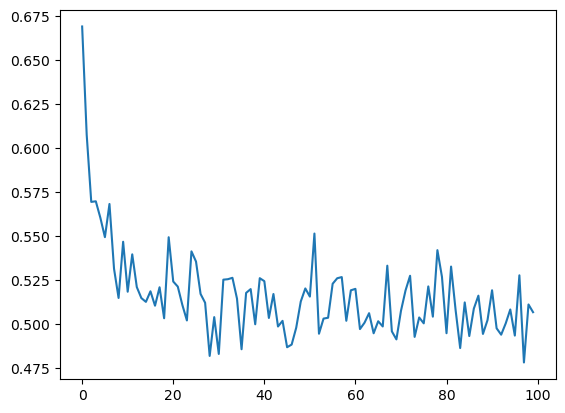

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### We can also use a confusion matrix to see the percent of correct guesses for training and test data

M confusion:  tensor([0.8293, 0.1707])
F confusion:  tensor([0.3093, 0.6907])


/var/folders/rb/k9pmvtxs1wv4y7fl9s364ybw0000gn/T/ipykernel_41647/4095328986.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/rb/k9pmvtxs1wv4y7fl9s364ybw0000gn/T/ipykernel_41647/4095328986.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


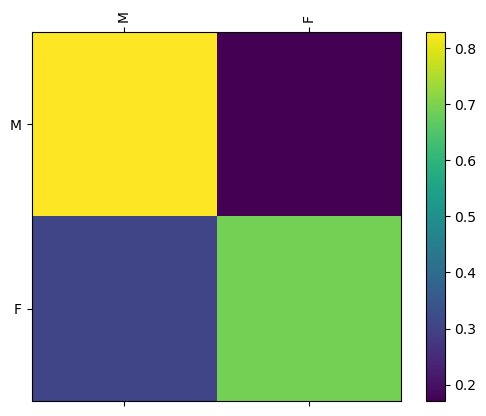

In [35]:
# Keep track of correct guesses in a confusion matrix
n_categories = 2
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
print("M confusion: ", confusion[0])
print("F confusion: ", confusion[1])

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

On the training data, the classifier predicts the gender of male names correctly more than 80% of the time but less than 70% of the time for female names. 

M confusion:  tensor([0.8367, 0.1633])
F confusion:  tensor([0.3095, 0.6905])


/var/folders/rb/k9pmvtxs1wv4y7fl9s364ybw0000gn/T/ipykernel_41647/1099538935.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/rb/k9pmvtxs1wv4y7fl9s364ybw0000gn/T/ipykernel_41647/1099538935.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


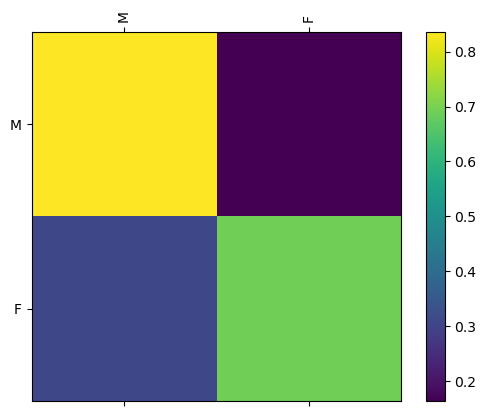

In [36]:
# Keep track of correct guesses in a confusion matrix
n_categories = 2
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTestExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
print("M confusion: ", confusion[0])
print("F confusion: ", confusion[1])

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

We get quite similar values on the held out dataset, indicating that our classifier is not over trained 

### Results:
The classifier is significantly more accurate at guessing the gender of male names and less so for female names which is quite interesting. However, at least based on the training example guesses, I believe the accuracy for the classifier is not far off from what the human accuracy would be. Additionally, the performance does not significantly differ between the evaluating on the training and test datasets which indicate that the classifier is not overtrained and is able to generalize well to new data.